# __Transfer Learning - MXNet__

Setting up kaggle... yes!! We are gonna solve a categorical classification problem using transfer learning

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Downloading the dataset from kaggle

In [0]:
!mkdir dataset
!pwd
%cd dataset
!kaggle datasets download prasunroy/natural-images
!unzip natural-images.zip
%cd ..

### __Let's begin!__

In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
from mxnet.gluon.data import vision
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os

plt.style.use('seaborn')

ctx = mx.gpu()

## __Creating seperate directories for testing and validation__
And counting available training examples for each categories

In [3]:
train_root = "dataset/natural_images/"
val_root = "dataset/val/"
test_root = "dataset/test/"

os.mkdir(val_root)
os.mkdir(test_root)

categories = os.listdir(train_root)
categories.sort()

print("Categories:", categories)
print("Total Categories:", len(categories))

for category in categories:
    os.mkdir(os.path.join(val_root, category))    
    os.mkdir(os.path.join(test_root, category))
    print(f"{len(os.listdir(train_root + category))} images for '{category}' category")

Categories: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
Total Categories: 8
567 images for 'airplane' category
808 images for 'car' category
725 images for 'cat' category
542 images for 'dog' category
683 images for 'flower' category
840 images for 'fruit' category
628 images for 'motorbike' category
826 images for 'person' category


## __Creating Validation and Testing datasets__
In validation -> 50 examples for each category

And in testing -> 150 examples for each category

In [8]:
for category in categories:
    print(f"Creating validation and testing dataset for '{category}' category")
    for _ in range(10):
        images = os.listdir(train_root + category)
        idx = int(nd.random.randint(0, len(images)).asscalar())
        image = images[idx]
        os.rename(os.path.join(train_root, category, image), os.path.join(val_root, category, image))

    for _ in range(150):
        images = os.listdir(train_root + category)
        idx = int(nd.random.randint(0, len(images)).asscalar())
        image = images[idx]
        os.rename(os.path.join(train_root, category, image), os.path.join(test_root, category, image))

Creating validation and testing dataset for 'airplane' category
Creating validation and testing dataset for 'car' category
Creating validation and testing dataset for 'cat' category
Creating validation and testing dataset for 'dog' category
Creating validation and testing dataset for 'flower' category
Creating validation and testing dataset for 'fruit' category
Creating validation and testing dataset for 'motorbike' category
Creating validation and testing dataset for 'person' category


## __Below are the bar plots regarding availability of examples in each category__

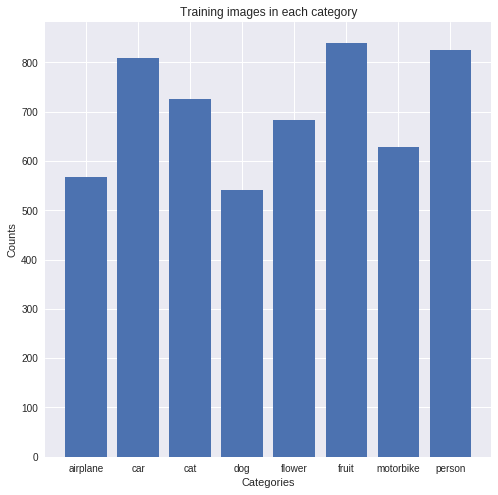

In [9]:
train_counts = []
for category in categories:
    train_counts.append(len(os.listdir(train_root + category)))
plt.figure(figsize = (8,8))
plt.bar(categories, train_counts)
plt.title('Training images in each category')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

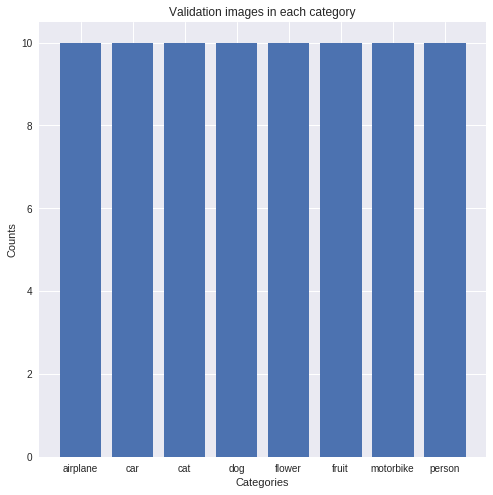

In [10]:
val_counts = []
for category in categories:
    val_counts.append(len(os.listdir(val_root + category)))
plt.figure(figsize = (8,8))
plt.bar(categories, val_counts)
plt.title('Validation images in each category')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

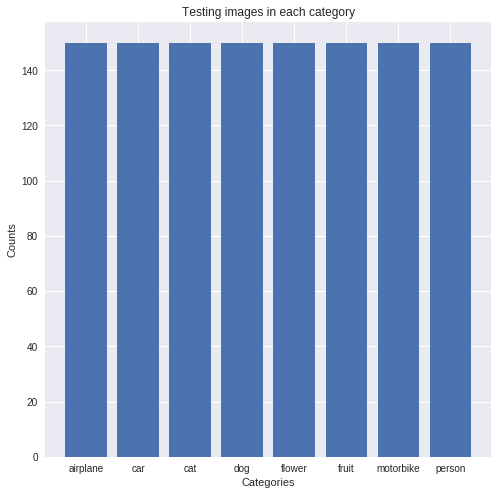

In [11]:
test_counts = []
for category in categories:
    test_counts.append(len(os.listdir(test_root + category)))
plt.figure(figsize = (8,8))
plt.bar(categories, test_counts)
plt.title('Testing images in each category')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

## __Creating data loaders for training, validation and testing, with data augmentation__

In [4]:
train_transform = vision.transforms.Compose([vision.transforms.RandomSaturation(saturation = 0.1),
                                vision.transforms.RandomLighting(alpha = 0.2),
                                vision.transforms.RandomHue(hue = 0.1),
                                vision.transforms.RandomFlipLeftRight(),
                                vision.transforms.RandomContrast(contrast = 0.2),
                                vision.transforms.RandomColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1, hue = 0.1),
                                vision.transforms.Resize(128),
                                vision.transforms.ToTensor()])

transform = vision.transforms.Compose([vision.transforms.Resize(128),
                                       vision.transforms.ToTensor()])

batch_size = 64

train_data = gluon.data.DataLoader(
                vision.ImageFolderDataset(root = train_root, flag = 1).transform_first(train_transform),
                batch_size = batch_size, shuffle = True)

val_data = gluon.data.DataLoader(
                vision.ImageFolderDataset(root = val_root, flag = 1).transform_first(transform),
                batch_size = batch_size, shuffle = False)

test_data = gluon.data.DataLoader(
                vision.ImageFolderDataset(root = test_root, flag = 1).transform_first(transform),
                batch_size = batch_size, shuffle = False)

print(f"{len(train_data)} batches in training data")
print(f"{len(val_data)} batches in validation data")
print(f"{len(test_data)} batches in testing data")

88 batches in training data
2 batches in validation data
19 batches in testing data


## __Making sure that our dataset is normalized__

In [5]:
for features, labels in train_data:
    break

print(f"features.shape: {features.shape}")
print(f"labels.shape: {labels.shape}")

print(f"features.max(): {features.max().asscalar()}")
print(f"features.min(): {features.min().asscalar()}")

features.shape: (64, 3, 128, 128)
labels.shape: (64,)
features.max(): 1.0
features.min(): 0.0


## __Visualizing some sample examples__

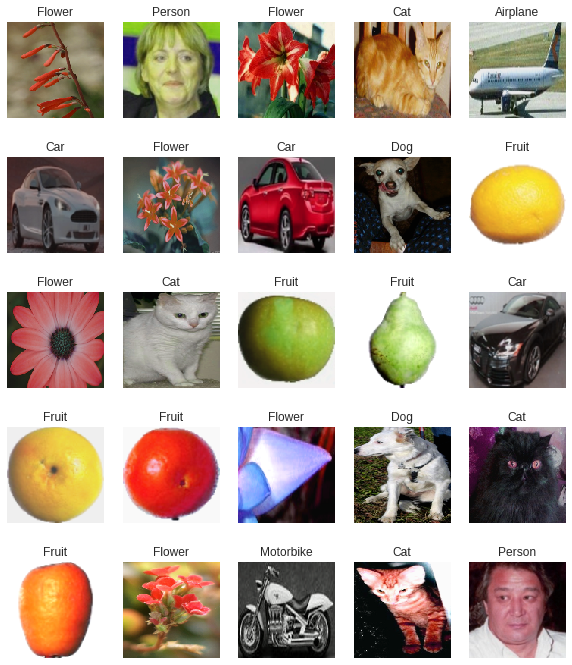

In [6]:
plt.figure(figsize = (10, 12))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(features[i].transpose((1, 2, 0)).asnumpy())
    plt.title(categories[int(labels[i].asscalar())].title())
    plt.axis("off")
plt.show()

## __Getting the pretrained model calles MobileNet__
Note that for the final output block we are adding an additional dropout layer following with a final output dense layer with number of neurons equal to no of categories

In [9]:
model = gluon.model_zoo.vision.mobilenet_v2_1_0(pretrained = True, ctx = ctx)

with model.name_scope():
    model.output.add(nn.Dropout(0.5))
    model.output.add(nn.Dense(len(categories)))
model.output.initialize(mx.init.Xavier(), ctx = ctx)

print(model)

MobileNetV2(
  (features): HybridSequential(
    (0): Conv2D(3 -> 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
    (2): RELU6(
    
    )
    (3): LinearBottleneck(
      (out): HybridSequential(
        (0): Conv2D(32 -> 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
        (2): RELU6(
        
        )
        (3): Conv2D(1 -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
        (5): RELU6(
        
        )
        (6): Conv2D(32 -> 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=16)

/usr/local/lib/python3.6/dist-packages/mxnet/gluon/parameter.py:862: UserWarning: Parameter 'mobilenetv22_output_pred_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)


In [10]:
model.summary(features.as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                           (64, 3, 128, 128)               0
            Conv2D-1                            (64, 32, 64, 64)             864
         BatchNorm-2                            (64, 32, 64, 64)             128
             RELU6-3                            (64, 32, 64, 64)               0
            Conv2D-4                            (64, 32, 64, 64)            1024
         BatchNorm-5                            (64, 32, 64, 64)             128
             RELU6-6                            (64, 32, 64, 64)               0
            Conv2D-7                            (64, 32, 64, 64)             288
         BatchNorm-8                            (64, 32, 64, 64)             128
             RELU6-9                            (64, 32, 64, 64)               0
           Conv2D-10        

## __Hybridizing the model and defining our objective loss and optimizer__

In [0]:
model.hybridize()
objective = gluon.loss.SoftmaxCrossEntropyLoss()
optimizer = mx.optimizer.Adam(learning_rate = 0.0005)
trainer = gluon.Trainer(model.collect_params(), optimizer)
metric = mx.metric.Accuracy()

## __Training the model__

In [12]:
epochs = 10
batches = len(train_data)

train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_val = 0.0

for epoch in range(epochs):
    metric.reset()
    cum_loss = 0.0
    for features, labels in tqdm(train_data, desc = f'Epoch: {epoch + 1} Completed', ncols = 800):
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx)

        with autograd.record():
            outputs = model(features)
            loss = objective(outputs, labels)
        loss.backward()
        trainer.step(batch_size)

        cum_loss += loss.mean()
        metric.update(labels, outputs)

    train_loss = cum_loss.asscalar()/batches
    train_acc = metric.get()[1]

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    metric.reset()
    cum_loss = 0.0
    for features, labels in test_data:
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx)
        outputs = model(features)
        metric.update(labels, outputs)
        cum_loss += objective(outputs, labels).mean()

    val_loss = cum_loss.asscalar()/batches
    val_acc = metric.get()[1]

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f'Training Loss:\t {train_loss:.5f} | Training Accuracy:   {train_acc:.5f}')
    print(f'Validation Loss: {val_loss:.5f} | Validation Accuracy: {val_acc:.5f}')
    if val_acc > best_val:
        print('Saving model for best validation accuracy')
        model.save_parameters('model.params')
        best_val = val_acc


Training Loss:	 0.66388 | Training Accuracy:   0.92757
Validation Loss: 0.02251 | Validation Accuracy: 0.97250
Saving model for best validation accuracy



Training Loss:	 0.08045 | Training Accuracy:   0.97597
Validation Loss: 0.00570 | Validation Accuracy: 0.98917
Saving model for best validation accuracy



Training Loss:	 0.02639 | Training Accuracy:   0.99039
Validation Loss: 0.00575 | Validation Accuracy: 0.99083
Saving model for best validation accuracy



Training Loss:	 0.07342 | Training Accuracy:   0.98167
Validation Loss: 0.00879 | Validation Accuracy: 0.98667



Training Loss:	 0.03771 | Training Accuracy:   0.98808
Validation Loss: 0.02475 | Validation Accuracy: 0.98167



Training Loss:	 0.13925 | Training Accuracy:   0.97153
Validation Loss: 0.02816 | Validation Accuracy: 0.96583



Training Loss:	 0.07177 | Training Accuracy:   0.98220
Validation Loss: 0.01136 | Validation Accuracy: 0.98750



Training Loss:	 0.03856 | Training Accuracy:   0.98914
Validation Loss: 0.01196 | Validation Accuracy: 0.98583



Training Loss:	 0.01985 | Training Accuracy:   0.99288
Validation Loss: 0.01135 | Validation Accuracy: 0.98667



Training Loss:	 0.04440 | Training Accuracy:   0.99110
Validation Loss: 0.01497 | Validation Accuracy: 0.97333


## __Visializing the training progress__

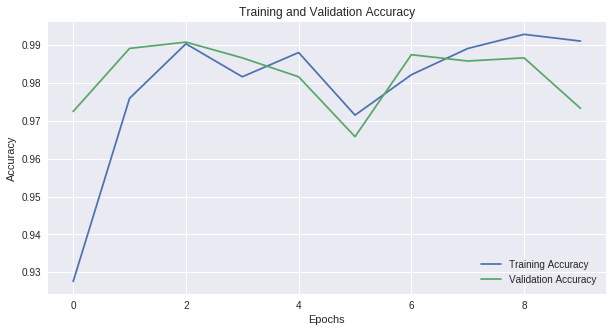

In [13]:
plt.figure(figsize = (10, 5))
plt.plot(train_accs, label = 'Training Accuracy')
plt.plot(val_accs, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

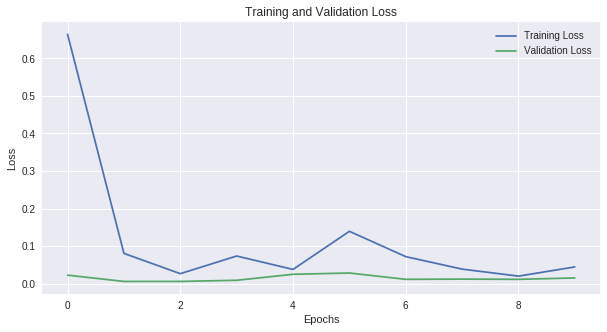

In [14]:
plt.figure(figsize = (10, 5))
plt.plot(train_losses, label = 'Training Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## __Loading the parameters to the model with best validation accuracy__

In [0]:
model.load_parameters('model.params')

In [17]:
metric.reset()
for features, labels in test_data:
    features = features.as_in_context(ctx)
    labels = labels.as_in_context(ctx)
    outputs = model(features)
    metric.update(labels, outputs)
print(f'Testing Accuracy: {metric.get()[1]}')

Testing Accuracy: 0.9908333333333333
